In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.decomposition import PCA

In [3]:
np.random.seed(0)
m = 1000
d = 2
n = 10

Z = np.random.normal(loc=0.0, scale=1.0, size = [m, d])
epsilon = np.random.normal(loc=0.0, scale=1.0, size = [m, n])

W = np.random.normal(loc=0.0, scale=1.0, size = [n, d])

X = Z@W.T+epsilon

In [4]:
print(Z.shape, W.shape, epsilon.shape, X.shape)

(1000, 2) (10, 2) (1000, 10) (1000, 10)


In [5]:
pca = PCA(n_components=d)

In [6]:
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [7]:
class BPCA():
    def __init__(self, n_components=2):
        self.__n_components = n_components
        self.__eye = np.eye(n_components)
        self.__W = None
        self.__mu = None
        self.__sigma = None
        return
    
    def fit(self, X):
        if self.__W is None:
            self.__W = np.random.rand(X.shape[1], self.__n_components)
        if self.__mu is None:
# \mu пересчитывается сразу раз и на всегда
            self.__mu = np.mean(X, axis = 0)
        if self.__sigma is None:
            self.__sigma = 1.0
        return self.__fit(X)
    
    def __fit(self, X):
        
        temp_S_2 = 0
        for k in range(X.shape[0]):
            temp_S_2 += np.reshape(np.reshape(self.__mu-X[k],[1,-1])@np.reshape(self.__mu-X[k],[-1,1]), -1)
        
        
        for i in range(200):
# E - шаг
            self.__A_WS = self.__find_A()
            A = self.__sigma*self.__A_WS
            
            M = np.zeros(shape = [X.shape[0], self.__n_components])
            for k in range(X.shape[0]):
                M[k] = self.__find_m(X[k])

            
# M - шаг
            temp_W_1 = 0
            temp_W_2 = 0
            
            for k in range(X.shape[0]):
                temp_W_1 += np.reshape(X[k] - self.__mu, [-1,1])@np.reshape(M[k], [1,-1])
                temp_W_2 += np.reshape(M[k], [-1,1])@np.reshape(M[k], [1,-1])
            
            self.__W = temp_W_1@np.linalg.inv(X.shape[0]*A+temp_W_2)
        

            temp_S_1 = 0
            temp_S_3 = 0
            for k in range(X.shape[0]):
                m = M[k]
                temp_S_3 += np.reshape(np.reshape(m,[1,-1])@self.__W.T@np.reshape(X[k]-self.__mu, [-1,1]), -1)
                temp_S_1 += np.reshape(m, [1,-1])@self.__W.T@self.__W@np.reshape(m, [-1,1])
            
            temp_S_1 += X.shape[0]*np.sum(np.diagonal(self.__W.T@self.__W@A))
            
            self.__sigma = float((temp_S_1+temp_S_2-2*temp_S_3))/(X.shape[0]*X.shape[1])

        return
    
    def parameters(self):
        return self.__W, self.__mu , self.__sigma
    
    def __find_A(self):
        return np.linalg.inv(self.__W.T@self.__W + self.__sigma*self.__eye)

    def __find_m(self, x):
        return np.reshape(self.__A_WS@self.__W.T@np.reshape(x - self.__mu, [-1,1]), -1)
 
    def __transform_proba(self, X):
        A_WS = self.__find_A()
        A = self.__sigma*A_WS
        Z = np.zeros(shape = [X.shape[0], self.__n_components])
        for i in range(X.shape[0]):
            m = self.__find_m(X[i])
            z = np.random.multivariate_normal(mean = m, cov = A)
            Z[i] = z
            
        return Z
    
    def __transform_predictable(self, X):
        Z = np.zeros(shape = [X.shape[0], self.__n_components])
        for i in range(X.shape[0]):
            Z[i] = self.__find_m(X[i])
            
        return Z
    
    def transform(self, X, proba = False):
        if proba:
            return  self.__transform_proba(X)
        
        return self.__transform_predictable(X)
        

In [8]:
bpca = BPCA(n_components=d)

In [9]:
bpca.fit(X)

In [10]:
bayes_transformed = bpca.transform(X, proba=True)

In [11]:
pca_transformed = pca.transform(X)

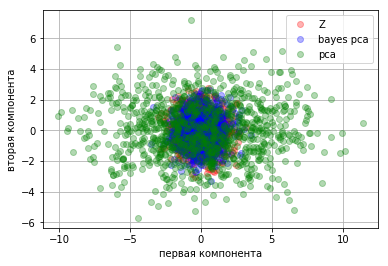

In [12]:
plt.plot(Z[:,0], Z[:,1], 'ro', alpha=0.3, label = 'Z')
plt.plot(bayes_transformed[:,0], bayes_transformed[:,1], 'bo', alpha=0.3, label = 'bayes pca')
plt.plot(pca_transformed[:,0], pca_transformed[:,1], 'go', alpha=0.3, label = 'pca')

plt.xlabel('первая компонента')
plt.ylabel('вторая компонента')

plt.legend(loc = 'best')

plt.grid()
plt.savefig('Task4_1.pdf')
plt.show()



In [46]:
class BPCA_C():
    def __init__(self):
        self.__n_components = None
        self.__mu = None
        self.__alpha = None
        self.__sigma = None
        self.__eye_d = None
        
        self.__M = None
        self.__A_WS = None
        self.__A = None
        self.__U = None
        self.__B_WS = None
        return
    
    def fit(self, X, epoch = 100):
        if self.__n_components is None:
            self.__n_components = X.shape[1]
        if self.__mu is None:
            self.__mu = np.mean(X, axis = 0)
        if self.__sigma is None:
            self.__sigma = 1.0
        if self.__alpha is None:
            self.__alpha = np.ones(shape = [X.shape[1]])
        if self.__eye_d is None:
            self.__eye_d = np.eye(self.__n_components)
        return self.__fit(X, epoch = epoch)
    
    def __init_q(self, X):
        self.__X_mean = np.mean(X, axis = 0)
        if self.__M is None:
            self.__M = np.random.rand(X.shape[0], self.__n_components)
        if self.__A_WS is None:
            self.__A_WS = np.eye(self.__n_components)
        if self.__A is None:
            self.__A = self.__sigma*self.__A_WS
        
        if self.__U is None:
            self.__U = np.random.rand(X.shape[1], self.__n_components)
        if self.__B_WS is None:
            self.__B_WS = np.zeros(shape = [X.shape[1], self.__n_components, self.__n_components])
            for k in range(X.shape[1]):
                self.__B_WS[k] = np.eye(self.__n_components)
        self.__B = self.__sigma*self.__B_WS
        
# __C is expectation of W.TW
        self.__C = np.diag(np.sum(np.diagonal(self.__B, axis1=1, axis2=2), axis = 1)) + np.diag(np.diagonal(self.__U.T@self.__U))

# __D is expectation of z_iz_i.T for all i 
        self.__D = np.zeros(shape = [X.shape[0], self.__n_components, self.__n_components])
        for k in range(X.shape[0]):
            self.__D[k] = self.__A + np.reshape(self.__M[k], [-1,1])@np.reshape(self.__M[k], [1,-1])    
        return
    
    def __E_step(self, X):
        
# пересчет Z
        self.__A_WS = self.__find_A()
        self.__A = self.__sigma*self.__A_WS
        for k in range(X.shape[0]):
            self.__M[k] = self.__find_m(X[k])
        for k in range(X.shape[0]):
            self.__D[k] = self.__A + np.reshape(self.__M[k], [-1,1])@np.reshape(self.__M[k], [1,-1])
        
# пересчет W        
        temp_B = np.sum(self.__D, axis = 0)
        for k in range(X.shape[1]):
            self.__B_WS[k] = np.linalg.inv(temp_B + self.__sigma*np.diag(self.__alpha))
        self.__B = self.__sigma*self.__B_WS
        
        temp_U_1 = 0
        for k in range(X.shape[0]):
            temp_U_1 += np.reshape(X[k] - self.__mu, [-1,1])@np.reshape(self.__M[k], [1,-1])
        temp_U_2 = np.linalg.inv(np.sum(self.__D, axis = 0) + self.__sigma*np.diag(self.__alpha))
        self.__U = temp_U_1@temp_U_2
        
        self.__C = np.diag(np.sum(np.diagonal(self.__B, axis1=1, axis2=2), axis = 1)) + np.diag(np.diagonal(self.__U.T@self.__U))

        return
    
    def __M_step(self, X):
# пересчитываем альфа
        for k in range(X.shape[1]):
            self.__alpha[k] = self.__n_components/(np.sum(np.diagonal(self.__B[k])) + np.sum(self.__U[:,k]**2))

# пересчитываем mu
        self.__mu = self.__X_mean

# пересчитываем sigma
        temp_S_1 = np.sum(np.diagonal(np.sum(self.__D, axis = 0)@self.__C))
        temp_S_2 = 0
        for k in range(X.shape[0]):
            temp_S_2 += np.reshape(np.reshape(self.__mu-X[k],[1,-1])@np.reshape(self.__mu-X[k],[-1,1]), -1)
        temp_S_3 = 0
        for k in range(X.shape[0]):
            temp_S_3 += np.reshape(self.__M[k], [1,-1])@self.__U.T@np.reshape(self.__mu - X[k], [-1,1])
        temp_S_3 = 2*temp_S_3
        self.__sigma = float((temp_S_1+temp_S_2+temp_S_3)/(X.shape[0]*X.shape[1]))
        
        return
    
    def __fit(self, X, epoch = 100):
        
        self.__init_q(X)
        
        for i in range(epoch):
            
            self.__E_step(X)
            self.__M_step(X)
        
        pass
    
    def __find_A(self):
        return np.linalg.inv(self.__C + self.__sigma*self.__eye_d)
    
    def __find_m(self, x):
        return np.reshape(self.__A_WS@self.__U.T@np.reshape(x - self.__mu, [-1,1]), -1)
 

    def parameters(self):
        return self.__alpha, self.__mu , self.__sigma

    def __transform_proba(self, X):
        A_WS = self.__find_A()
        A = self.__sigma*A_WS
        Z = np.zeros(shape = [X.shape[0], self.__n_components])
        for i in range(X.shape[0]):
            m = self.__find_m(X[i])
            z = np.random.multivariate_normal(mean = m, cov = A)
            Z[i] = z
            
        return Z
    
    def __transform_predictable(self, X):
        Z = np.zeros(shape = [X.shape[0], self.__n_components])
        for i in range(X.shape[0]):
            Z[i] = self.__find_m(X[i])
            
        return Z
        
    
    def transform(self, X, proba = False):
        if proba:
            return  self.__transform_proba(X)
        
        return self.__transform_predictable(X)
        

In [47]:
bpca_C = BPCA_C()

In [49]:
bpca_C.fit(X, epoch = 2000)

In [50]:
alpha_C, mu_C, sigma_C = bpca_C.parameters()

In [51]:
mu_C

array([-0.02542351,  0.04733543, -0.09979558, -0.06084243,  0.00081435,
       -0.01183099, -0.0062685 , -0.02465008, -0.02007632, -0.02026399])

In [52]:
sigma_C

0.9214641997152565

In [53]:
alpha_C

array([  2.43719724e+03,   2.43719724e+03,   3.10573896e+00,
         2.43719724e+03,   1.22735892e+00,   2.43719724e+03,
         2.43719724e+03,   2.43719724e+03,   2.43719724e+03,
         2.43719724e+03])

In [54]:
bayes_C_transformed = bpca_C.transform(X, proba=True)

In [56]:
bayes_C_transformed.shape

(1000, 10)

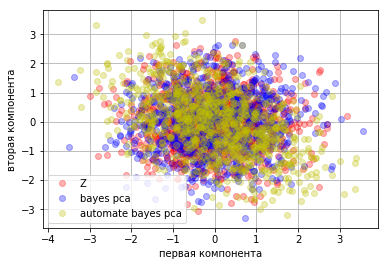

In [60]:
plt.plot(Z[:,0], Z[:,1], 'ro', alpha=0.3, label = 'Z')
plt.plot(bayes_transformed[:,0], bayes_transformed[:,1], 'bo', alpha=0.3, label = 'bayes pca')
# plt.plot(pca_transformed[:,0], pca_transformed[:,1], 'go', alpha=0.3, label = 'pca')
plt.plot(bayes_C_transformed[:,4], bayes_C_transformed[:,2], 'yo', alpha=0.3, label = 'automate bayes pca')


plt.xlabel('первая компонента')
plt.ylabel('вторая компонента')

plt.legend(loc = 'best')

plt.grid()
plt.savefig('Task4_2.pdf')
plt.show()


